# RetinaMNIST

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during Lecture 8. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits randomly selected from `MNIST` dataset on a canvas of size `(128, 128)`. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [2]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            str(self.class_nb),
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
           class_nb=class_nb,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [3]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)

    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit = digits[current_digit_index]
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=classes[current_digit_index],
        ):
            attempts_done += 1
    return new_canvas

11493376/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas:

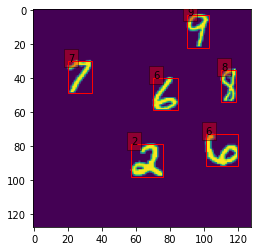

In [4]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

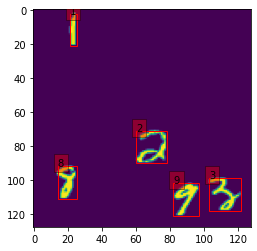

In [5]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (0.5pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

max  x : 19
max  y : 19
mean x : 18.712151616499444
mean y : 14.80891861761427


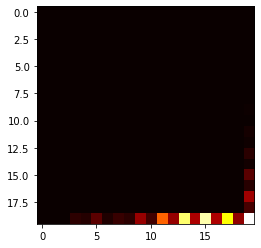

In [6]:
n_of_canvases = 1000
random_canvases = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(n_of_canvases)]
boxes = [c.boxes for c in random_canvases]
flat_boxes = [b for bs in boxes for b in bs]
box_sizes = [(b.x_diff, b.y_diff) for b in flat_boxes]
max_x = max([x for (x,y) in box_sizes])
max_y = max([y for (x,y) in box_sizes])

print("max  x :", max_x)
print("max  y :", max_y)
print("mean x :", np.mean([x for (x,y) in box_sizes]))
print("mean y :", np.mean([y for (x,y) in box_sizes]))

sizes_count = np.zeros((max_x+1, max_y+1))
for (x,y) in box_sizes:
    sizes_count[x,y] = sizes_count[x,y] + 1



plt.imshow(sizes_count, cmap='hot', interpolation='nearest')

plt.show()

# we can see that the max x and max y are 19, and that at least one of dimentions is maximal.
# we also see that the x tends is ussualy bigger than y dimention (probably counterintuitively x is height and y is width)

# i checked it at n = 10k, but the results are pretty much the same

ANCHOR_SIZES = [(19, 9), (19, 13), (19, 15), (19, 17), (19, 19), (17, 19)]

### Model building (1pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

Backbone model should accept a `MnistCanvas` instance and output a tensor with shape $(1, \frac{128}{2^k}, \frac{128}{2^k}, filters)$ where $k \in {2, 3, 4}$ and $filters$ should be selected by student. We will later relate to selected $k$ as a stride. You can use a pretrained backbone.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 2^k, \left(n + \frac{1}{2}\right) * 2^k\right)$  for $m, n \in \{0, 1, \dots, \frac{128}{2^k} - 1\}$.

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{classificationHead}$:

$\texttt{classificationHead}$ should accept backbone output as an input and output `classification_output` tensor of shape $(len(\texttt{anchors)}, 10)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j$(ground truth box).

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [7]:
import torchvision.models as models

resnet = models.resnet34(pretrained=True)

def get_backbone(k=3):
    assert(2 <= k <= 4)
    return torch.nn.Sequential(*list(resnet.children())[:-(2 + 5 - k)]).to(DEVICE)
my_model = get_backbone(3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [8]:
print(my_model)  
x = random_canvases[0].get_torch_tensor().repeat(1,3,1,1)
y = my_model(x)
y.shape


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

torch.Size([1, 128, 16, 16])

In [10]:
import itertools
import torchvision.models as models
import torchvision 

class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.classification_output = classification_output
        self.box_regression_output = box_regression_output


class MyBackbone(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.LeakyReLU()
            )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2) # 64 x 64
            )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2) # 32 x 32
            )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2) # 16 x 16
            )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


class ClassificationHead(torch.nn.Module):
    def __init__(self, anchors_per_tile, filters):
        super().__init__()
     
        self.anchors_per_tile = anchors_per_tile
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(filters, 128, kernel_size=3, padding=1),
            torch.nn.LeakyReLU()
            )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, anchors_per_tile * 10, kernel_size=3, padding=1),
            )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.swapaxes(1,2).swapaxes(2,3).reshape((-1, 10))

        return x

class BoxRegressionHead(torch.nn.Module):
    def __init__(self, anchors_per_tile, filters):
        super().__init__()

        self.anchors_per_tile = anchors_per_tile
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(filters, 128, kernel_size=3, padding=1),
            torch.nn.LeakyReLU()
            )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, anchors_per_tile * 4, kernel_size=3, padding=1),
            )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.swapaxes(1,2).swapaxes(2,3).reshape((-1, 4))

        return x

class DigitDetectionModel(torch.nn.Module):
    def __init__(
        self,
        k,
        filters=128
    ):
         super().__init__()
         self.k = k
         self.grid_cell_size = 128 // 2**k
         self.grid_size = 2**k 
         self.anchors = [
             MnistBox(
                 (m + 0.5) * self.grid_size - x_diff // 2,
                 (n + 0.5) * self.grid_size - y_diff // 2,
                 (m + 0.5) * self.grid_size + x_diff - (x_diff // 2),
                 (n + 0.5) * self.grid_size + y_diff - (y_diff // 2),
             )
             for (m, n, (x_diff, y_diff)) in itertools.product(
                 range(self.grid_cell_size),
                 range(self.grid_cell_size),
                 ANCHOR_SIZES)
         ]
        #  self.backbone = get_backbone(k).to(DEVICE)
         self.backbone = MyBackbone().to(DEVICE)
         self.classification_head = ClassificationHead(len(ANCHOR_SIZES), filters).to(DEVICE)
         self.box_regression_head = BoxRegressionHead(len(ANCHOR_SIZES), filters).to(DEVICE)

    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        # Note that this is defined for a single MnistCanvas
        input = x.get_torch_tensor().repeat(1,3,1,1)
        backbone_output = self.backbone(input)
        self.backbone_output = backbone_output
        classification_output = self.classification_head(backbone_output)
        box_regression_output = self.box_regression_head(backbone_output)
        return DigitDetectionModelOutput(self.anchors, classification_output, box_regression_output)

### Significant overlap (1pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `classification_target` - a tensor of shape $(len(anchors), 10)$,
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

and `classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{class_targets}[i, \texttt{gt_best.class_nb}] = 1.$$

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [11]:
class DigitDetectionModelTarget:

    def __init__(
        self,
        classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.classification_target = classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.5,
        nb_of_classes: int = 10,
    ) -> DigitDetectionModelTarget:
        gt_boxes = canvas.boxes

        iou_overlaps = [[a.iou_with(gtb) for gtb in gt_boxes] for a in anchors]

        best_overlap = [np.argmax(overlaps) for overlaps in iou_overlaps]
        best_classes = [gt_boxes[best].class_nb if iou_overlaps[i][best] >= iou_threshold else -1
            for best, i in zip (best_overlap, range(len(best_overlap)))]
        best_boxes = [gt_boxes[best] if iou_overlaps[i][best] >= iou_threshold else None
            for best, i in zip (best_overlap, range(len(best_overlap)))]
       
        classification_target = torch.tensor([[1 if i == best_class else 0 for i in range(nb_of_classes)] for best_class in best_classes]).to(DEVICE)
        box_regression_target = torch.tensor([[0,0,0,0] if gt_best == None else [
            gt_best.x_min - anchor.x_min,
            gt_best.x_max - anchor.x_max,
            gt_best.y_min - anchor.y_min,
            gt_best.y_max - anchor.y_max,
        ] for anchor, gt_best in zip(anchors, best_boxes)]).to(DEVICE)

        matched_anchors = [i for i, bst in zip(range(len(anchors)), best_classes) if bst >= 0]
        
        return DigitDetectionModelTarget(classification_target, box_regression_target, matched_anchors)

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        adjusted_boxes = [MnistBox(
            a.x_min + br[0],
            a.y_min + br[2],
            a.x_max + br[1],
            a.y_max + br[3],
            clss.argmax().item()
        ) for a, br, clss in zip(model_output.anchors, model_output.box_regression_output, model_output.classification_output)]
        nms_boxes = torch.tensor([[b.x_min, b.y_min, b.x_max, b.y_max] for b in adjusted_boxes]).to(DEVICE).float()
        nms_scores = torch.tensor([max(classes) for classes in model_output.classification_output]).to(DEVICE).float()
        nms_iou_treshold = 0.1
        new_boxes_ids = torchvision.ops.nms(nms_boxes, nms_scores, nms_iou_treshold)
        return [adjusted_boxes[i] for i in new_boxes_ids if nms_scores[i] >= 0.01]

In [13]:
model = DigitDetectionModel(3)

canvas_id = 420

canvas = random_canvases[canvas_id]

td = TargetDecoder()
targets = td.get_targets(canvas, model.anchors, iou_threshold=0.3)

dout = DigitDetectionModelOutput(model.anchors, targets.classification_target, targets.box_regression_target)

# not actually predicted, but I used them to simulate predictions
predicted_boxes = td.get_predictions(dout)

Mnist Box: x_min = 67.0, x_max = 86.0, y_min = 64.0, y_max = 73.0. Class = None
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([ 0.,  0., -7., -4.])


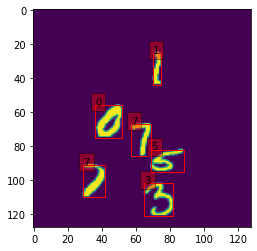

In [15]:
print(model.anchors[912])
print(targets.classification_target[912])
print(targets.box_regression_target[912])
anchors_to_show = []

canvas.plot()

In [16]:
print(canvas.boxes)

[Mnist Box: x_min = 25, x_max = 44, y_min = 70, y_max = 75. Class = 1, Mnist Box: x_min = 82, x_max = 95, y_min = 69, y_max = 88. Class = 5, Mnist Box: x_min = 102, x_max = 121, y_min = 65, y_max = 82. Class = 3, Mnist Box: x_min = 67, x_max = 86, y_min = 57, y_max = 69. Class = 7, Mnist Box: x_min = 56, x_max = 75, y_min = 36, y_max = 52. Class = 0, Mnist Box: x_min = 91, x_max = 110, y_min = 29, y_max = 42. Class = 7]


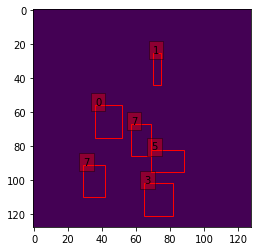

In [17]:
mc = MnistCanvas(np.zeros((128,128)), predicted_boxes)
mc.plot()

### Metrics (0.5pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between classes predictions and targets averaged only over matched anchors.

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [19]:
import torch
import torchvision 


class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]: 
        matched_nb = len(model_target.matched_anchors)
        if matched_nb == 0:
            return None 
        boxes_criteria = torch.nn.SmoothL1Loss(reduction="sum")
        
        def classification_criteria(inputs, targets):
             return torchvision.ops.sigmoid_focal_loss(inputs, targets, reduction="sum", alpha=0.25, gamma=2)


        box_loss = boxes_criteria(
            model_output.box_regression_output.float(),
            model_target.box_regression_target.float()) / matched_nb
        class_loss = classification_criteria(
            model_output.classification_output.float(),
            model_target.classification_target.float()) / matched_nb

        return box_loss + class_loss
        

class DigitAccuracy:

    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
        log=False
    ):
        if len(canvas.boxes) != len(predicted_boxes):
            if log:
                print(f'PB: {len(predicted_boxes)}, CB: {len(canvas.boxes)}')
            return 0
        for gt_box in canvas.boxes:
            if np.sum([
                1 if gt_box.iou_with(pr_box) >= 0.5 and gt_box.class_nb == pr_box.class_nb else 0
                for pr_box in predicted_boxes]) != 1:
                return 0
        return 1
    
    def compute_weak_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        score = 0
        for gt_box in canvas.boxes:
            box_hit = np.sum([ 1 if gt_box.iou_with(pr_box) >= 0.5 and gt_box.class_nb == pr_box.class_nb else 0 for pr_box in predicted_boxes])
            
            if box_hit == 1:
                score = score + 1
        return score / len(canvas.boxes)
        


In [21]:
### Train your model (1pt)

# One should use all classes defined above to train the model.

# A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

# Plot example results of matched and mismatched predictions (0.5pt).

# _Hint:_ note that all classes defined above accept only a single canvas as their inputs. Can we extend a training loop to use it for a training on batches?

# Have fun!

In [22]:
import time

def train(model, optimizer, max_epochs, train_size, dev_size, pseudo_batch_size=10, iou_threshold=0.3):
    round_num = 6

    dev_losses = []
    dev_accs = []
    train_losses = []
    train_accs = []

    td = TargetDecoder()
    rl = RetinaLoss()
    da = DigitAccuracy()

    for epoch in range(max_epochs):
        start = time.perf_counter()
        # Training
        train_loss = 0
        train_correct = 0
        weak_correct = 0
        model.train()
        cumulated_loss = 0
        counter = 0
        for i in range(train_size):
            canvas = get_random_canvas()

            prediction = model(canvas)
            target = td.get_targets(canvas, model.anchors, iou_threshold)

            predicted_boxes = td.get_predictions(prediction)

            correct = da.compute_metric(predicted_boxes, canvas)
            weak_correct = weak_correct + da.compute_weak_metric(predicted_boxes, canvas)

            loss = rl.compute_loss(prediction, target)

            if loss == None:
                print('LOSS NONE (what does it say about your anchors??)')
            else:
                cumulated_loss += loss
                train_loss = train_loss + loss
                counter = counter + 1
            
            train_correct = train_correct + correct 

            if i % pseudo_batch_size == 0:
                optimizer.zero_grad()
                cumulated_loss.backward()
                optimizer.step()
                cumulated_loss = 0

        counter = max(counter, 0.000001)
        train_acc = train_correct / counter
        train_loss = train_loss / counter
        weak_acc = weak_correct / counter
        train_losses.append(train_loss.item())
        train_accs.append(train_acc)

        # Validation
        dev_loss = 0
        dev_correct = 0
        model.eval()
        counter = 0
        max_class = -10000
        with torch.set_grad_enabled(False):
            for i in range(dev_size):
                canvas = get_random_canvas()

                prediction = model(canvas)

                max_class = max(max_class, prediction.classification_output.max().item())
                target = td.get_targets(canvas, model.anchors, iou_threshold)
                predicted_boxes = td.get_predictions(prediction)

                correct = da.compute_metric(predicted_boxes, canvas)
                loss = rl.compute_loss(prediction, target)
                if loss == None:
                    print('LOSS NONE (what does it say about your anchors??)')
                else:
                    dev_loss = dev_loss + loss
                    counter = counter + 1
                
                dev_correct = dev_correct + correct
        
        counter = max(counter, 0.000001)
        dev_acc = dev_correct / counter
        dev_loss = dev_loss / counter
        dev_losses.append(dev_loss.item())
        dev_accs.append(dev_acc)
        time_passed = time.perf_counter() - start
        mins =  int(time_passed // 60)
        sec = time_passed - mins * 60
        print('Epoch : ',epoch+1, '\t',
            'train_loss :', round(train_loss.item(), round_num),
            'train_acc:', round(train_acc, round_num),
            'dev_loss :', round(dev_loss.item(), round_num),
            'dev_acc:', round(dev_acc, round_num),
            'max_class:', round(max_class, round_num),
            'weak_acc:', round(weak_acc, round_num)
             )
        print('TIME: ', f'{mins}m{round(sec, 2)}')
    return dev_losses, dev_accs, train_losses, train_accs

In [23]:
model = DigitDetectionModel(3)
# optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.8, dampening=0, nesterov=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)



In [24]:
prm = []
for parameter in model.parameters():
    prm.append(parameter)
print(len(prm))

20


In [25]:
max_epochs = 50
train_size = 500
dev_size = 50
dev_losses, dev_accs, train_losses, train_accs = train(model, optimizer, max_epochs, train_size, dev_size, pseudo_batch_size=1, iou_threshold=0.3)

Epoch :  1 	 train_loss : 11.982495 train_acc: 0.0 dev_loss : 8.949903 dev_acc: 0.0 max_class: -0.150689 weak_acc: 0.0
TIME:  2m58.22
Epoch :  2 	 train_loss : 8.067126 train_acc: 0.0 dev_loss : 8.616905 dev_acc: 0.0 max_class: -0.168504 weak_acc: 0.0
TIME:  2m56.93
Epoch :  3 	 train_loss : 6.64999 train_acc: 0.0 dev_loss : 5.945323 dev_acc: 0.0 max_class: -0.231803 weak_acc: 0.0
TIME:  2m58.25
Epoch :  4 	 train_loss : 5.869467 train_acc: 0.0 dev_loss : 5.114465 dev_acc: 0.0 max_class: 0.173925 weak_acc: 0.003067
TIME:  2m58.52
Epoch :  5 	 train_loss : 5.260433 train_acc: 0.0 dev_loss : 4.782979 dev_acc: 0.0 max_class: 1.071016 weak_acc: 0.038967
TIME:  2m58.24
Epoch :  6 	 train_loss : 4.839842 train_acc: 0.002 dev_loss : 4.85145 dev_acc: 0.0 max_class: 1.278991 weak_acc: 0.129067
TIME:  2m58.8
Epoch :  7 	 train_loss : 4.632898 train_acc: 0.004 dev_loss : 4.742006 dev_acc: 0.02 max_class: 1.713015 weak_acc: 0.2165
TIME:  2m59.93
Epoch :  8 	 train_loss : 4.282095 train_acc: 0.01 d

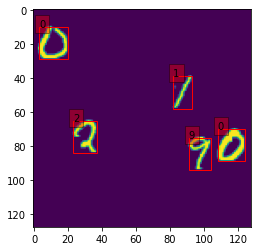

In [26]:
test_canvas = get_random_canvas()
test_canvas.plot()

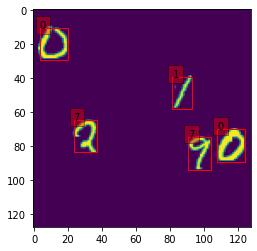

In [27]:
res = model(test_canvas)
td = TargetDecoder()
predicted_boxes = td.get_predictions(res)

img = test_canvas.get_torch_tensor().reshape((128, 128)).numpy()

pred_canvas = MnistCanvas(img, predicted_boxes)
pred_canvas.plot()

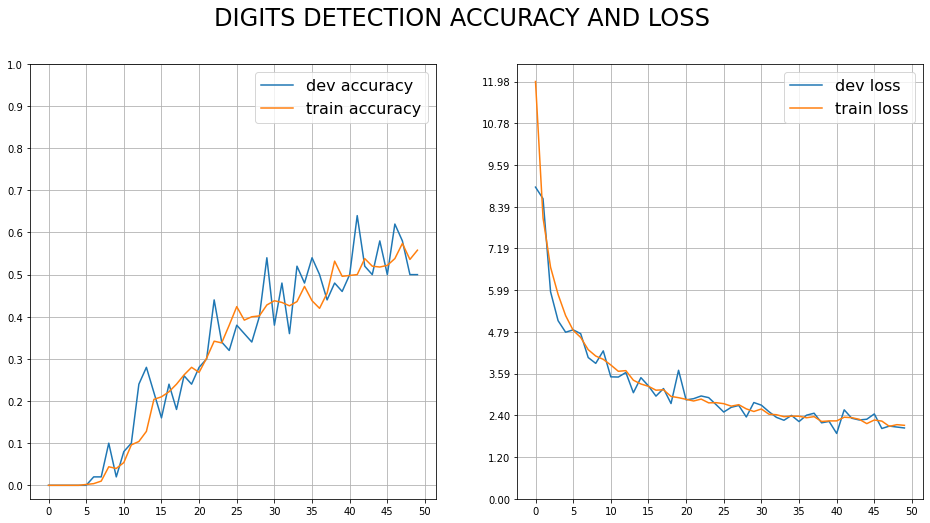

In [34]:
max_loss = max(max(dev_losses), max(train_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'DIGITS DETECTION ACCURACY AND LOSS', fontsize=24)
ax1.plot(dev_accs)
ax1.plot(train_accs)
ax1.legend(['dev accuracy', 'train accuracy'], fontsize=16)
ax1.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid()

ax2.plot(dev_losses)
ax2.plot(train_losses)
ax2.legend(['dev loss', 'train loss'], fontsize=16)
ax2.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax2.set_yticks(np.arange(0, max_loss + 0.01, max_loss/10))
ax2.grid()

fig.show()

In [ ]:
torch.save(model.state_dict(), './trained_model')

In [38]:
val_loss = 0
counter = 0
val_correct = 0

td = TargetDecoder()
rl = RetinaLoss()
da = DigitAccuracy()

with torch.set_grad_enabled(False):
    for canvas in TEST_CANVAS:
        # Model computations

        prediction = model(canvas)

        target = td.get_targets(canvas, model.anchors, iou_threshold=0.3)
        predicted_boxes = td.get_predictions(prediction)

        correct = da.compute_metric(predicted_boxes, canvas)
        loss = rl.compute_loss(prediction, target)
        if loss == None:
            print('LOSS NONE (what does it say about your anchors??)')
        else:
            val_loss = val_loss + loss
            counter = counter + 1
        
        val_correct = val_correct + correct

counter = max(counter, 0.000001)
val_acc = val_correct / counter
val_loss = val_loss / counter

print('VALIDATION: acc: ', val_acc, 'loss: ', val_loss)

VALIDATION: acc:  0.40625 loss:  tensor(2.0969)
